### Data extraction, transformation and loading

In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [2]:
print('Starting script at: ', datetime.datetime.now())

Starting script at:  2018-04-12 12:48:20.867070


In [3]:
test = pd.read_csv('Input/test.csv')
train  = pd.read_csv('Input/train.csv')

In [4]:
print('Data imported at: ', datetime.datetime.now())

Data imported at:  2018-04-12 12:48:23.015496


In [5]:
# Fill missing values with 0s
test.fillna(0, axis=1, inplace=True)
train.fillna(0, axis=1, inplace=True)

In [6]:
# Hot one encode city category for both test and train
onehot_encoder = OneHotEncoder(sparse=False)
city_catArray = np.array(train['City_Category'])
label_encoder = LabelEncoder()
city_cat_integer_encoded = label_encoder.fit_transform(city_catArray)
city_cat_onehot_encoder = OneHotEncoder(sparse=False)
city_cat_integer_encoded = city_cat_integer_encoded.reshape(len(city_cat_integer_encoded), 1)
city_cat_onehot_encoded = onehot_encoder.fit_transform(city_cat_integer_encoded)
City_Cat_Columns = set(test['City_Category'])
City_Cat_Columns = list(City_Cat_Columns)
dfCityCat = pd.DataFrame(data=city_cat_onehot_encoded, columns=City_Cat_Columns)

train = pd.concat([train, dfCityCat], axis=1, join='inner')

onehot_encoder = OneHotEncoder(sparse=False)
city_catArray = np.array(test['City_Category'])
label_encoder = LabelEncoder()
city_cat_integer_encoded = label_encoder.fit_transform(city_catArray)
city_cat_onehot_encoder = OneHotEncoder(sparse=False)
city_cat_integer_encoded = city_cat_integer_encoded.reshape(len(city_cat_integer_encoded), 1)
city_cat_onehot_encoded = onehot_encoder.fit_transform(city_cat_integer_encoded)
City_Cat_Columns = set(train['City_Category'])
City_Cat_Columns = list(City_Cat_Columns)
dfCityCat = pd.DataFrame(data=city_cat_onehot_encoded, columns=City_Cat_Columns)

test = pd.concat([test, dfCityCat], axis=1, join='inner')

In [7]:
# Set value of each age bin to average and set to type int
train.loc[train.Age == '0-17', 'Age'] = '14'
train.loc[train.Age == '18-25', 'Age'] = '21'
train.loc[train.Age == '26-35', 'Age'] = '30'
train.loc[train.Age == '36-45', 'Age'] = '40'
train.loc[train.Age == '46-50', 'Age'] = '48'
train.loc[train.Age == '51-55', 'Age'] = '53'
train.loc[train.Age == '55+', 'Age'] = '62'

test.loc[test.Age == '0-17', 'Age'] = '14'
test.loc[test.Age == '18-25', 'Age'] = '21'
test.loc[test.Age == '26-35', 'Age'] = '30'
test.loc[test.Age == '36-45', 'Age'] = '40'
test.loc[test.Age == '46-50', 'Age'] = '48'
test.loc[test.Age == '51-55', 'Age'] = '53'
test.loc[test.Age == '55+', 'Age'] = '62'

train.Age = train.Age.astype(int)
test.Age = test.Age.astype(int)

In [8]:
# Convert stay in current city to integer for test and train
train.loc[train.Stay_In_Current_City_Years == '4+', 'Stay_In_Current_City_Years'] = '4'
test.loc[test.Stay_In_Current_City_Years == '4+', 'Stay_In_Current_City_Years'] = '4'

train.Stay_In_Current_City_Years = train.Stay_In_Current_City_Years.astype(int)
test.Stay_In_Current_City_Years = test.Stay_In_Current_City_Years.astype(int)

In [9]:
# Hot one encode gender in a single column
train.loc[train.Gender == 'M', 'Gender'] = '1'
train.loc[train.Gender == 'F', 'Gender'] = '0'

test.loc[test.Gender == 'M', 'Gender'] = '1'
test.loc[test.Gender == 'F', 'Gender'] = '0'

train.Gender = train.Gender.astype(int)
test.Gender = test.Gender.astype(int)

In [10]:
print('Data cleaned at : ', datetime.datetime.now())

Data cleaned at :  2018-04-12 12:48:25.847166


### Feature Engineering

In [11]:
print('Feature engineering started at : ', datetime.datetime.now())

Feature engineering started at :  2018-04-12 12:48:25.852864


In [12]:
# Create number purchases per user feature
numPurchU = train.groupby(by='User_ID')['Purchase'].count().reset_index().rename(columns={'Purchase': 'NumPurchasesU'})
train = train.merge(numPurchU, on='User_ID', how='left')
test = test.merge(numPurchU, on= 'User_ID', how='left')

In [13]:
# Create number purchases per product feature
numPurchP = train.groupby(by='Product_ID')['Purchase'].count().reset_index().rename(columns={'Purchase': 'NumPurchasesP'})
train = train.merge(numPurchP, on='Product_ID', how='left')
test = test.merge(numPurchP, on= 'Product_ID', how='left')

In [14]:
# Create average purchase per user feature
avgPurchU = train.groupby(by='User_ID')['Purchase'].mean().reset_index().rename(columns={'Purchase': 'AvgPurchaseU'})
train = train.merge(avgPurchU, on='User_ID', how='left')
test = test.merge(avgPurchU, on= 'User_ID', how='left')

In [15]:
# Create average purchase per product feature
avgPurchP = train.groupby(by='Product_ID')['Purchase'].mean().reset_index().rename(columns={'Purchase': 'AvgPurchaseP'})
train = train.merge(avgPurchP, on='Product_ID', how='left')
test = test.merge(avgPurchP, on= 'Product_ID', how='left')

In [16]:
# Create proportion of user purchases higher than average purchase
# of product feature
train.loc[train.Purchase > train.AvgPurchaseP, 'High'] = 1
train.loc[train.Purchase < train.AvgPurchaseP, 'High'] = 0

propHighU = train.groupby('User_ID')['High'].mean().reset_index().rename(columns={'High': 'PropHighU'})
train = train.merge(propHighU, on='User_ID', how='left')
test = test.merge(propHighU, on='User_ID', how='left')

In [17]:
print("Created the following features:\n Number of purchases per user \n Number of purchases per product \n Average purchase amount per user \n Average purchase amount per product \n Proportion of purchases above average product purchase per user")

Created the following features:
 Number of purchases per user 
 Number of purchases per product 
 Average purchase amount per user 
 Average purchase amount per product 
 Proportion of purchases above average product purchase per user


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550068 entries, 0 to 550067
Data columns (total 21 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null int64
Age                           550068 non-null int64
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null int64
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            550068 non-null float64
Product_Category_3            550068 non-null float64
Purchase                      550068 non-null int64
A                             550068 non-null float64
B                             550068 non-null float64
C                             550068 non-null float64
NumPurchasesU                 550068 non-null int64
NumPurchasesP                 550068 non-null

In [19]:
trainFIC = train

y = trainFIC.Purchase
x = trainFIC.drop(['User_ID', 'Product_ID', 'City_Category', 'Purchase'], axis=1)

In [20]:
for col in x.columns:
    if sum(x[col].isnull()) > 1:
        print('Column ', col, ' contains nans')
        
        # Imputes the average for the column found to contain nulls i.e. std Product
        x[col].fillna((x[col].mean()), inplace=True)

Column  High  contains nans


In [21]:
rfr = RandomForestRegressor(n_jobs=-1, oob_score= True, random_state = 0, max_features=17)

rfr.fit(x,y)
 
importance = list(rfr.feature_importances_)
feature = list(x.columns)

feature_importance = pd.DataFrame({'Feature': feature, 'Importance': importance})

print('Feature importance determined from random forest')
print(feature_importance.sort_values('Importance', ascending=False))

Feature importance determined from random forest
                       Feature  Importance
14                AvgPurchaseP    0.736667
15                        High    0.174143
13                AvgPurchaseU    0.015516
16                   PropHighU    0.014717
11               NumPurchasesU    0.011849
12               NumPurchasesP    0.009816
5           Product_Category_1    0.009561
2                   Occupation    0.006638
1                          Age    0.004339
6           Product_Category_2    0.004123
3   Stay_In_Current_City_Years    0.004006
7           Product_Category_3    0.002970
4               Marital_Status    0.001446
0                       Gender    0.001268
9                            B    0.001078
8                            A    0.001009
10                           C    0.000854


/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Checking for feature correlation


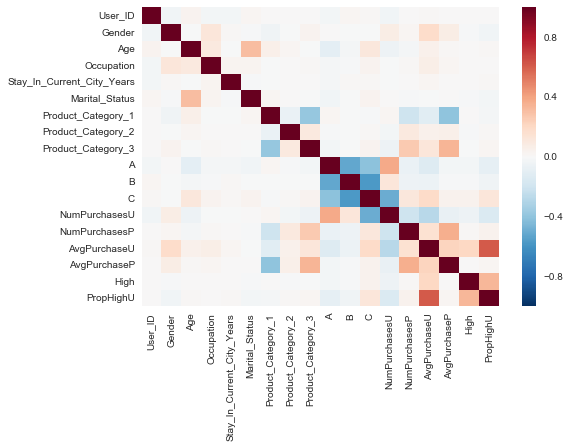

In [22]:
print('Checking for feature correlation')

plt.gcf().clear()

corr = train.drop('Purchase', axis=1).corr()
#print(corr)
sns.heatmap(corr)
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()

In [23]:
print(corr)

                             User_ID    Gender       Age  Occupation  \
User_ID                     1.000000 -0.033474  0.035795   -0.023971   
Gender                     -0.033474  1.000000 -0.005375    0.117291   
Age                         0.035795 -0.005375  1.000000    0.095514   
Occupation                 -0.023971  0.117291  0.095514    1.000000   
Stay_In_Current_City_Years -0.030737  0.014660 -0.003869    0.030005   
Marital_Status              0.020443 -0.011603  0.310183    0.024280   
Product_Category_1          0.003825 -0.045594  0.061422   -0.007618   
Product_Category_2          0.003896 -0.000954  0.019098    0.006712   
Product_Category_3          0.003605  0.036146 -0.007255    0.012269   
A                          -0.030568  0.007299 -0.095975   -0.023070   
B                           0.019688 -0.006155 -0.016509   -0.011673   
C                           0.008272 -0.000426  0.109476    0.034529   
NumPurchasesU              -0.032458  0.073517 -0.053153   -0.00

In [24]:
print('Features Engineering completed at : ', datetime.datetime.now())

Features Engineering completed at :  2018-04-12 12:49:03.104190


In [25]:
train.to_csv('Hold/train2.csv', index=False)
test.to_csv('Hold/test2.csv', index=False)